Setup the Keras Environment

In [38]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

Construct the Encoder

In [39]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z = layers.Dense(latent_dim, name="z")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 flatten_4 (Flatten)         (None, 6272)              0         
                                                                 
 dense_7 (Dense)             (None, 16)                100368    
                                                                 
 z (Dense)                   (None, 2)                 34  

Construct the Decoder

In [40]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 6272)              18816     
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_11 (Conv2  (None, 14, 14, 128)       147584    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_12 (Conv2  (None, 28, 28, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_13 (Conv2  (None, 28, 28, 32)        1846

Define the AE as a Class with Custom Training

In [41]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        #self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),
        }

Train the Model

In [42]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

ae = AE(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam())
history = ae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 131s 232ms/step - loss: 226.6870 - reconstruction_loss: 185.4811
Epoch 2/30
547/547 [==============================] - 141s 258ms/step - loss: 157.8190 - reconstruction_loss: 154.9206
Epoch 3/30
547/547 [==============================] - 141s 257ms/step - loss: 149.5754 - reconstruction_loss: 148.6858
Epoch 4/30
547/547 [==============================] - 131s 239ms/step - loss: 146.2052 - reconstruction_loss: 145.7447
Epoch 5/30
547/547 [==============================] - 131s 239ms/step - loss: 143.8218 - reconstruction_loss: 143.8290
Epoch 6/30
547/547 [==============================] - 137s 250ms/step - loss: 142.3529 - reconstruction_loss: 142.4435
Epoch 7/30
547/547 [==============================] - 145s 264ms/step - loss: 141.5402 - reconstruction_loss: 141.2679
Epoch 8/30
547/547 [==============================] - 199s 364ms/step - loss: 140.3841 - reconstruction_loss: 140.2495
Epoch 9/30
547/547 [============================

In [43]:
print(history.history.keys())

dict_keys(['loss', 'reconstruction_loss'])


Plot the loss function

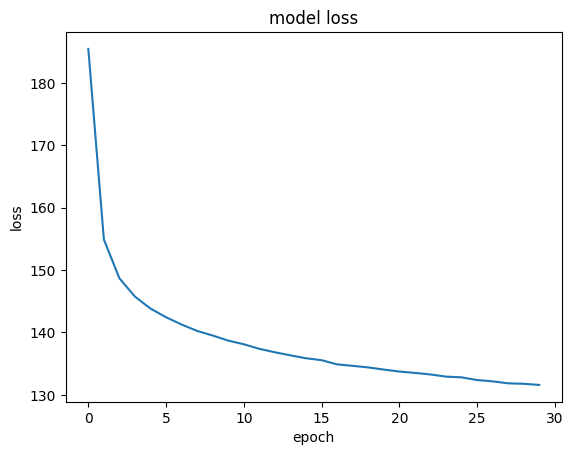

In [44]:
# summarize history for accuracy
plt.plot(history.history['reconstruction_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()


Save the Model Weights

In [45]:
ae.save_weights('./P1.1_AE_mnist_latent2.weights.h5')

Display a grid of sampled digits

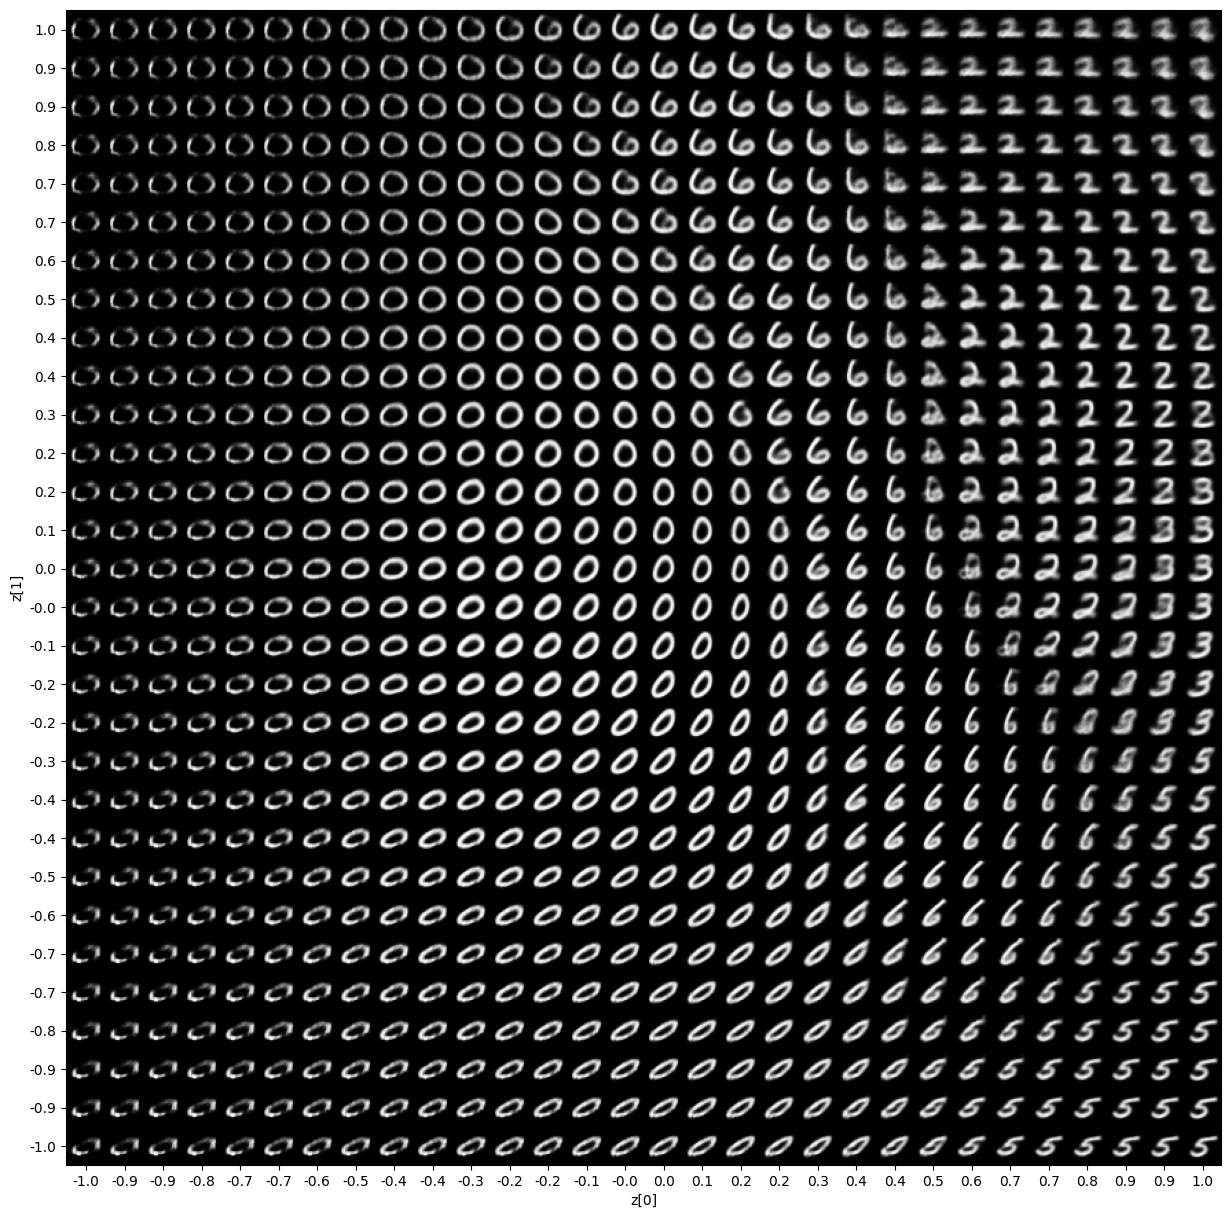

In [46]:
def plot_latent_space(ae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = ae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(ae)

Display how the latent space clusters different digit classes

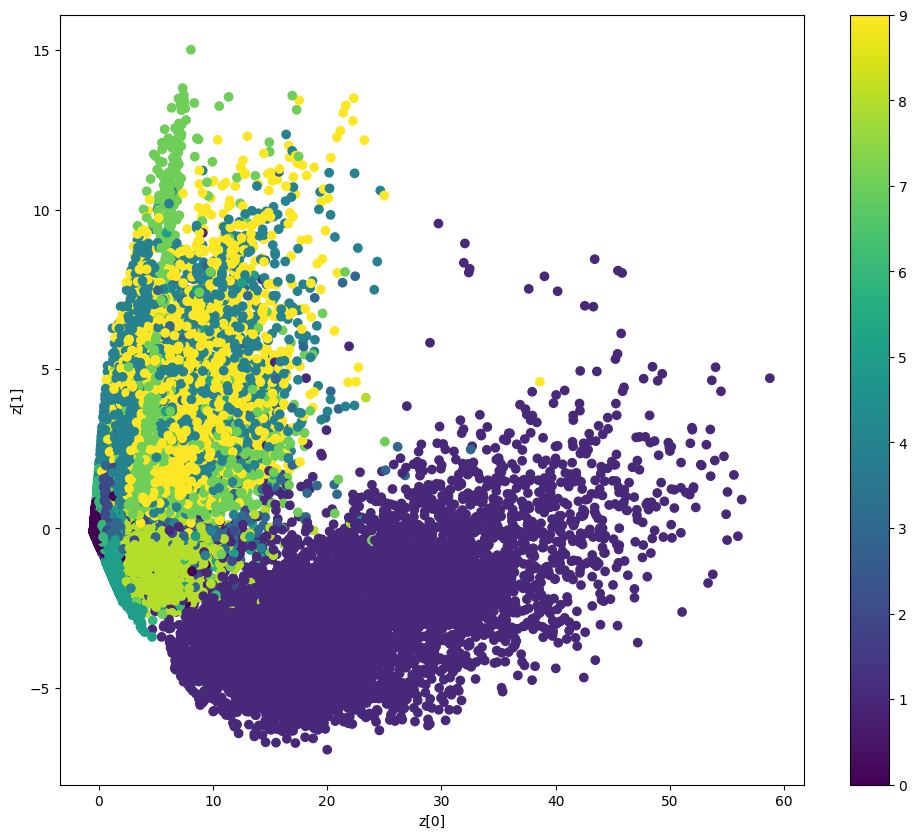

In [47]:
def plot_label_clusters(ae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean = ae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(ae, x_train, y_train)